# Regularisation, Parameter Initialisation, Batchnorm, Optimisers

Create and compare different models (as described below).

Inspect the results by using tensorboard.


In [1]:
import tensorflow as tf
import datetime
import os

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Parameters


In [3]:
layersizes = [50,50,50,10]
batchsize = 32 
epochs = 20
learning_rate = 0.1

tensorboard_folder = "tb_logs_keras"
outdir = os.path.join(os.getcwd(), tensorboard_folder)

### Baseline Model

* No regularisation
* No Batch Norm
* Default parameter initialisation of Keras: What is the default?
* Sigmoid activation (last layer always softmax)
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Now, create the baseline model. 

Possibly, add convenient naming to the layers so that you can more easily read the outputs in tensorboard. 

In [34]:
def baseline_model(layersizes, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    activation -- string specifying the activation function for the hidden layers to be used.
    
    """
    ### START YOUR CODE HERE ###

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[0],
                                    use_bias=True,
                                    activation=activation,
                                    name='Layer_{}'.format(0)))
    
    for i, ls in enumerate(layersizes[1:-1]):
        model.add(tf.keras.layers.Dense(units=ls,
                                        use_bias=True,
                                        activation=activation,
                                        name='Layer_{}'.format(i+1)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[-1],
                                    use_bias=True,
                                    activation='softmax',
                                    name='Layer_{}'.format(len(layersizes)-1)))
    
    ### STOP YOUR CODE HERE ###

    return model

In [35]:
model = baseline_model(layersizes, 'sigmoid')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
Layer_0 (Dense)              (None, 50)                39250     
_________________________________________________________________
Layer_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
Layer_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
Layer_3 (Dense)              (None, 10)                510       
Total params: 44,860
Trainable params: 44,860
Non-trainable params: 0
_________________________________________________________________


#### Run model

Use cross entropy as loss function.

In [37]:
x_train.shape

(60000, 28, 28)

In [38]:
y_train.shape

(60000,)

In [49]:
run_name = "baseline"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)
# start tensorboard on command line with tensorboard -logs <path to outdir> 


### START YOUR CODE HERE ###
""""
Use this sparse_categorical_crossentropy loss function when there
are two or more label classes. We expect labels to be provided
as integers. If you want to provide labels using one-hot
representation, please use CategoricalCrossentropy loss.
"""
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

### STOP YOUR CODE HERE ###


Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2193 - accuracy: 0.9404 - val_loss: 0.2292 - val_accuracy: 0.9382
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2183 - accuracy: 0.9418 - val_loss: 0.2233 - val_accuracy: 0.9384
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2130 - accuracy: 0.9427 - val_loss: 0.2197 - val_accuracy: 0.9396
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2026 - accuracy: 0.9453 - val_loss: 0.2147 - val_accuracy: 0.9419
Epoch 5/20
1875/1875 [==============================] - 2s 887us/step - loss: 0.1976 - accuracy: 0.9469 - val_loss: 0.2112 - val_accuracy: 0.9417
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1986 - accuracy: 0.9471 - val_loss: 0.2063 - val_accuracy: 0.9431
Epoch 7/20
1875/1875 [==============================] - 2s 914us/step - loss: 0.1884 - accuracy: 0.9487 - val_loss: 0.2053 - val_accur

#### OUTPUTs

Provide here suitable plots and comments:

* Learning curves: train / test accuracy and loss


In [54]:
for key, value in history.history.items():
  print(key)

loss
accuracy
val_loss
val_accuracy


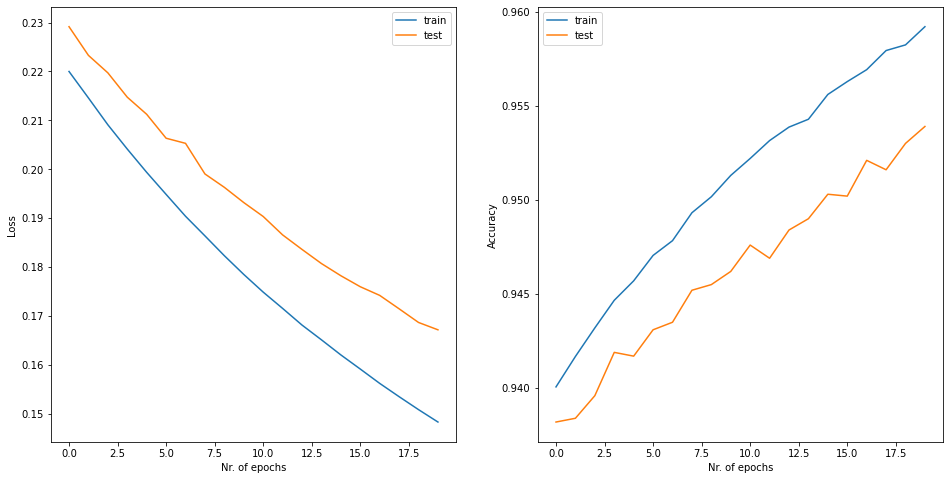

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##### Conclusion from the plots above
The loss start with a rather high value and decreases significantly over time/number of epochs. A similar behaviour can be observed in the accuracy plot, after the first epoch the accuracy is already pretty good (93-94%) and rises significantly over time/number of epochs. These are very nice plots, which indicates perfectly, that our model would highly benefit from longer training sessions/larger number of epochs.

### Parameter Initialisation

* No regularisation
* No Batch Norm
* __Parameter Initialisation: Compare GlorotNormal, Random Normal (mean 0, stdev 1), Zero, HeNormal__
* __Sigmoid Activation (last layer always softmax): Compare Sigmoid, ReLu__
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Hence, for each of the 4 initializers train and test a model sigmoid and relu.

In [10]:
def model_param_init(layersizes, initializer, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    initializer -- weight initializer
    activation -- string specifying the activation function to be used.
    
    """
    ### START YOUR CODE HERE ###


    
    
    
    
    
    ### STOP YOUR CODE HERE ###

    return model

#### Run model

Run with the different settings.
Don't forget to configure the proper tensorboard callback.

In [6]:
### START YOUR CODE HERE ###











### STOP YOUR CODE HERE ###

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 177us/sample - loss: 0.7767 - accuracy: 0.7752 - val_loss: 0.3102 - val_accuracy: 0.9117
Epoch 2/10
60000/60000 [==============================] - 11s 176us/sample - loss: 0.2555 - accuracy: 0.9260 - val_loss: 0.2086 - val_accuracy: 0.9386
Epoch 3/10
60000/60000 [==============================] - 11s 181us/sample - loss: 0.1866 - accuracy: 0.9450 - val_loss: 0.1688 - val_accuracy: 0.9491
Epoch 4/10
60000/60000 [==============================] - 11s 184us/sample - loss: 0.1528 - accuracy: 0.9552 - val_loss: 0.1464 - val_accuracy: 0.9581
Epoch 5/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.1316 - accuracy: 0.9615 - val_loss: 0.1370 - val_accuracy: 0.9616
Epoch 6/10
60000/60000 [==============================] - 11s 186us/sample - loss: 0.1178 - accuracy: 0.9654 - val_loss: 0.1307 - val_accuracy: 0.9617
Epoch 7/10
60000/60000 [====================

#### OUTPUTs

Provide here suitable plots and comments:

* Comparison of the different learning curves: 
    * train accuracy vs epochs for different models
    * train loss vs epochs for different models
    * test accuracy vs epochs for different models
    * test loss vs epochs for different models
    
Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of parameter initialisation become more clear?

### Batch Normalisation

* No regularisation
* __Batch Norm__: with / without 
* __Parameter Initialisation: Random Normal (0,1), GlorotNormal__
* __Activation: Compare Sigmoid, ReLu__
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Run with/without batchnorm in combination with sigmoid or relu (with GlorotNormal).<br>
Run with/without batchnorm in combination with GlorotNormal or RandomNormal (with sigmoid).<br>
Hence run 8 different models.

In [2]:
def model_batchnorm(layersizes, initializer, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    initializer -- weight initializer
    activation -- string specifying the activation function to be used.
    """
    ### START YOUR CODE HERE ###


    
    
    
    
    
    ### STOP YOUR CODE HERE ###

    return model

#### Run model

Run the different variants.

In [6]:
### START YOUR CODE HERE ###










### STOP YOUR CODE HERE ###

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 177us/sample - loss: 0.7767 - accuracy: 0.7752 - val_loss: 0.3102 - val_accuracy: 0.9117
Epoch 2/10
60000/60000 [==============================] - 11s 176us/sample - loss: 0.2555 - accuracy: 0.9260 - val_loss: 0.2086 - val_accuracy: 0.9386
Epoch 3/10
60000/60000 [==============================] - 11s 181us/sample - loss: 0.1866 - accuracy: 0.9450 - val_loss: 0.1688 - val_accuracy: 0.9491
Epoch 4/10
60000/60000 [==============================] - 11s 184us/sample - loss: 0.1528 - accuracy: 0.9552 - val_loss: 0.1464 - val_accuracy: 0.9581
Epoch 5/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.1316 - accuracy: 0.9615 - val_loss: 0.1370 - val_accuracy: 0.9616
Epoch 6/10
60000/60000 [==============================] - 11s 186us/sample - loss: 0.1178 - accuracy: 0.9654 - val_loss: 0.1307 - val_accuracy: 0.9617
Epoch 7/10
60000/60000 [====================

#### OUTPUTs

Provide here suitable plots and comments:

* Comparison of the different learning curves: 
    * train accuracy vs epochs for different models
    * train loss vs epochs for different models
    * test accuracy vs epochs for different models
    * test loss vs epochs for different models
    
* Inspect the histograms of the activations and compare them for the different models.

* Find the max learning rate for the model with and without Batch Norm. 

Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of batch norm become more clear?

### Optimizers

* No regularisation
* No BatchNorm 
* Parameter Initialisation: GlorotNormal
* Activation: ReLu
* Optimizers: Compare 
    * SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop)
    * RmsProp
    * Momentum

Create an according model and train it with the different optimizers.

#### OUTPUTs

TODO: 
* Comparison of the different learning curves: 
    * train accuracy vs epochs for optimizers
    * train loss vs epochs for optimizers
    * test accuracy vs epochs for optimizers
    * test loss vs epochs for optimizers
    
Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of the different optimizers become more clear?